In [ ]:
# Download the data
# !wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary.csv
# !wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary_more.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [ ]:
# Install necessary libraries
# Note: You may need to restart your kernel!
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install pandas
!pip3 install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize

In [ ]:
import pandas as pd

summary = pd.read_csv('./dataset/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('./dataset/news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
pre1 =  raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep = " "),sep = " "), sep = " ")

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']], ignore_index = True)

In [ ]:
pre.head(10)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."
5,Pakistani singer Rahat Fateh Ali Khan has deni...,Rahat Fateh Ali Khan denies getting notice for...
6,India recorded their lowest ODI total in New Z...,"India get all out for 92, their lowest ODI tot..."
7,Weeks after ex-CBI Director Alok Verma told th...,Govt directs Alok Verma to join work 1 day bef...
8,Andhra Pradesh CM N Chandrababu Naidu has said...,Called PM Modi 'sir' 10 times to satisfy his e...
9,Congress candidate Shafia Zubair won the Ramga...,"Cong wins Ramgarh bypoll in Rajasthan, takes t..."


In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
    
    for row in column:        
        row = re.sub("(\\t)", ' ', str(row)).lower() 
        row = re.sub("(\\r)", ' ', str(row)).lower() 
        row = re.sub("(\\n)", ' ', str(row)).lower()
        
        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", ' ', str(row)).lower()   
        
        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", ' ', str(row)).lower()
        
        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", ' ', str(row)).lower()   
        
        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", ' ', str(row)).lower()   
        
        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", ' ', str(row)).lower()   
        
        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() 
        
        # Remove mailto:
        row = re.sub("(mailto:)", ' ', str(row)).lower() 
        
        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", ' ', str(row)).lower() 
        
        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        
        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        
        # Remove punctuations at the end of a word 
        row = re.sub("(\.\s+)", ' ', str(row)).lower() 
        row = re.sub("(\-\s+)", ' ', str(row)).lower() 
        row = re.sub("(\:\s+)", ' ', str(row)).lower() 
                
        # Replace any url to only the domain name
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
        
        # Remove multiple spaces
        row = re.sub("(\s+)",' ',str(row)).lower() 
        
        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        
        yield row

In [ ]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

In [ ]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=1000)]

summary = [str(doc) for doc in nlp.pipe(processed_summary, batch_size=1000)]

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [ ]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

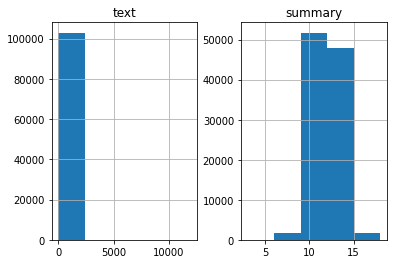

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.9578389933440218


In [ ]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 100
max_summary_len = 15

In [ ]:
# Select the Summaries and Text which fall below max length 
import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

In [ ]:
post_pre.head(10)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...
5,pakistani singer rahat fateh ali khan has deni...,_START_ rahat fateh ali khan denies getting no...
6,india recorded their lowest odi total in new z...,_START_ india get all out for 92 their lowest ...
7,weeks after ex-cbi director alok verma told th...,_START_ govt directs alok verma to join work d...
8,andhra pradesh cm chandrababu naidu has said w...,_START_ called pm modi sir 10 times to satisfy...
9,congress candidate shafia zubair won the ramga...,_START_ cong wins ramgarh bypoll in rajasthan ...


In [ ]:
# Add sostok and eostok at the start and end of the summary
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [ ]:
post_pre.head(10)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma-le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...
5,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
6,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
7,weeks after ex-cbi director alok verma told th...,sostok _START_ govt directs alok verma to join...
8,andhra pradesh cm chandrababu naidu has said w...,sostok _START_ called pm modi sir 10 times to ...
9,congress candidate shafia zubair won the ramga...,sostok _START_ cong wins ramgarh bypoll in raj...


In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']), test_size=0.5, random_state=0, shuffle=True)

In [ ]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ",(cnt / tot_cnt) * 100)

% of rare words in vocabulary:  63.502072279830344


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 22633


In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 65.48698237725723


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 9519


In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     4526600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2), 
      

In [ ]:
mc = ModelCheckpoint('./Model',monitor='val_loss', verbose=1, 
                      save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
# Note: this will take a while. Run as many epochs as needed.
history = model.fit([x_tr, y_tr[:,:-1]], 
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], 
                    epochs=15, 
                    callbacks=[es,mc], 
                    batch_size=128, 
                    validation_data=([x_val, y_val[:, :-1]], 
                                     y_val.reshape(y_val.shape[0], 
                                                   y_val.shape[1], 1)[:,1:])
                    )

Epoch 1/15
385/385 [==============================] - ETA: 0s - loss: 5.1707
Epoch 1: val_loss improved from inf to 4.79215, saving model to ./Model
385/385 [==============================] - 688s 2s/step - loss: 5.1707 - val_loss: 4.7921
Epoch 2/15
385/385 [==============================] - ETA: 0s - loss: 4.7868
Epoch 2: val_loss improved from 4.79215 to 4.63304, saving model to ./Model
385/385 [==============================] - 679s 2s/step - loss: 4.7868 - val_loss: 4.6330
Epoch 3/15
385/385 [==============================] - ETA: 0s - loss: 4.6309
Epoch 3: val_loss improved from 4.63304 to 4.50274, saving model to ./Model
385/385 [==============================] - 680s 2s/step - loss: 4.6309 - val_loss: 4.5027
Epoch 4/15
385/385 [==============================] - ETA: 0s - loss: 4.4800
Epoch 4: val_loss improved from 4.50274 to 4.40522, saving model to ./Model
385/385 [==============================] - 662s 2s/step - loss: 4.4800 - val_loss: 4.4052
Epoch 5/15
385/385 [============

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary.h5")
print("Saved model to disk")

Saved model to disk


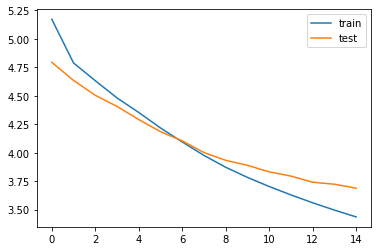

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
from tensorflow.keras.models import Model, load_model, model_from_json

# loading the model architecture and asigning the weights
json_file = open('summary.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)

# load weights into model
model_loaded.load_weights("summary.h5")

In [ ]:
# Inference Models

# Encoder Setup
# Loading encoder_inputs
encoder_inputs = model_loaded.input[0]  

# Loading encoder_outputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output 

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token != 'eostok'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if ((i != 0 and i != target_word_index['sostok']) and i!= target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
            
    return newString

# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '
            
    return newString

In [ ]:
import tkinter as tk
from tkinter import ttk

def clear_input(event):
    print("Button Clicked")

# set main windows size
window_width = 850
window_height = 500

main = tk.Tk()
main.title("Automatic Text Summarizer Using RNN")
main.resizable(False, False)

# get the screen dimension
screen_width = main.winfo_screenwidth()
screen_height = main.winfo_screenheight()

# find the center point
center_x = int(screen_width/2 - window_width / 2)
center_y = int(screen_height/2 - window_height / 2)

# set the position of the window to the center of the screen
main.geometry(f'{window_width}x{window_height}+{center_x}+{center_y}')

# set icon for windows
# main.iconbitmap()

# configure the grid
main.columnconfigure(0, weight=1)
main.columnconfigure(1, weight=1)

# place a label on the main windows
maintitle = ttk.Label(
    main, 
    text="Automatic Text Summarizer",
    font=("Helvetica", 17))

maintitle.grid(columnspan=2, row=0, sticky=tk.N, pady=40)

# string variable for storing input
inputText = tk.StringVar()
outputText = tk.StringVar()

# input textbox
text1 = tk.Text(main, height=15)
text1.grid(column=0, row=2, sticky=tk.E, padx=20)

# output textbox
text2 = tk.Text(main, height=15)
text2['state'] = 'disabled'
text2.grid(column=1, row=2, sticky=tk.W, padx=20)

# create style object
style = ttk.Style(main)

# Styling button
style.configure("TButton", background="blue")

# summarize button
button = ttk.Button(main, text='Summarize')
button.bind('<Return>', decode_sequence)
button.bind('<Button>', decode_sequence, add='+')
button.focus()
button.grid(column=0, row=3, sticky=tk.E, ipadx=10, ipady=10, padx=15, pady=45)

# clear button
button = ttk.Button(main, text='X')
button.bind('<Button>', clear_input)
button.focus()
button.grid(column=1, row=3, sticky=tk.W, padx=15)

main.mainloop()

TclError: ignored

In [ ]:
for i in range(0, 19):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print("\n")

Review: austrian authorities have been distributing flyers to inform austrian nationals and tourists about ban on face veils in public the flyers also warn that those violating the law face fines of up to over ã¢ââ¹11 000 the ban is aimed at encouraging people to into austrian culture the foreign ministry said 
Original summary: start austria distributes flyers people about burqa ban end 
1/1 [==============================] - 0s 23ms/step
Predicted summary:  start uk bans use of using food on sale end


Review: irish mixed martial artist conor mcgregor has said he half black below the waist in response to his alleged racist comments at opponent floyd mayweather during their press meet in new york mcgregor his in tribute to his black female fans mcgregor had said dance for me boy to mayweather in their earlier face off in los angeles 
Original summary: start i half black below mcgregor on racism allegations end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  s